## Module Import & Data Load

In [166]:
import sys

from pathlib import Path
from datetime import timedelta

import dateutil
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from tqdm.notebook import trange
from TaPR_pkg import etapr
from src import dataset
import tqdm

import pickle
from torchinfo import summary

In [167]:
# GPU 할당 변경하기
GPU_NUM = 0 # 원하는 GPU 번호 입력
device = torch.device(f'cuda:{GPU_NUM}' if torch.cuda.is_available() else 'cpu')
torch.cuda.set_device(device) # change allocation of current GPU

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.backends.cudnn.benchmark = True

# Define HAI Dataset for AE

In [168]:
# WINDOW_GIVEN = 90
# WINDOW_SIZE = 91

WINDOW_SIZE = 90

class HaiDataset(Dataset):
    def __init__(self, timestamps, df, stride=1, attacks=None):
        self.ts = np.array(timestamps)
        self.tag_values = np.array(df, dtype=np.float32)
        self.valid_idxs = []
        for L in trange(len(self.ts) - WINDOW_SIZE):
            R = L + WINDOW_SIZE
            if dateutil.parser.parse(self.ts[R]) - dateutil.parser.parse(self.ts[L]) == timedelta(seconds=WINDOW_SIZE):
                self.valid_idxs.append(L)
        self.valid_idxs = np.array(self.valid_idxs, dtype=np.int32)[::stride]
        self.n_idxs = len(self.valid_idxs)
        print(f"# of valid windows: {self.n_idxs}")
        if attacks is not None:
            self.attacks = np.array(attacks, dtype=np.float32)
            self.with_attack = True
        else:
            self.with_attack = False

    def __len__(self):
        return self.n_idxs

    def __getitem__(self, idx):
        i = self.valid_idxs[idx]
        item = {"attack": self.attacks[i : i + WINDOW_SIZE]} if self.with_attack else {}
        item["ts"] = self.ts[i + WINDOW_SIZE]
        item["given"] = torch.from_numpy(self.tag_values[i : i + WINDOW_SIZE])
        return item

In [169]:
def boundary_check(df):
    x = np.array(df, dtype=np.float32)
    return np.any(x > 1.0), np.any(x < 0), np.any(np.isnan(x))

In [170]:
TRAIN_DATASET = sorted([x for x in Path("HAICon2021_dataset/train/").glob("*.csv")])
TRAIN_DATASET

[PosixPath('HAICon2021_dataset/train/train1.csv'),
 PosixPath('HAICon2021_dataset/train/train2.csv'),
 PosixPath('HAICon2021_dataset/train/train3.csv'),
 PosixPath('HAICon2021_dataset/train/train4.csv'),
 PosixPath('HAICon2021_dataset/train/train5.csv'),
 PosixPath('HAICon2021_dataset/train/train6.csv')]

In [171]:
TEST_DATASET = sorted([x for x in Path("HAICon2021_dataset/test/").glob("*.csv")])
TEST_DATASET

[PosixPath('HAICon2021_dataset/test/test1.csv'),
 PosixPath('HAICon2021_dataset/test/test2.csv'),
 PosixPath('HAICon2021_dataset/test/test3.csv')]

In [172]:
VALIDATION_DATASET = sorted([x for x in Path("HAICon2021_dataset/validation/").glob("*.csv")])
VALIDATION_DATASET

[PosixPath('HAICon2021_dataset/validation/validation.csv')]

In [173]:
def dataframe_from_csv(target):
    return pd.read_csv(target).rename(columns=lambda x: x.strip())

def dataframe_from_csvs(targets):
    return pd.concat([dataframe_from_csv(x) for x in targets])

In [174]:
TRAIN_DF_RAW = dataframe_from_csvs(TRAIN_DATASET)
TRAIN_DF_RAW

,timestamp,C01,C02,C03,C04,C05,C06,C07,C08,C09,...,C77,C78,C79,C80,C81,C82,C83,C84,C85,C86
0,2021-07-11 10:00:00,-2.2642,0,12.26196,-0.00087,12.01019,0.2254,12.66931,70,1,...,0.92255,30.08042,7.08818,595.06104,276.40338,1,1014.79321,12.0,50,3506
1,2021-07-11 10:00:01,-2.4923,0,12.26196,0.00058,12.56714,-0.0711,12.66931,70,1,...,0.92255,30.08423,7.08818,531.50317,276.18634,1,1014.79321,12.0,50,3493
2,2021-07-11 10:00:02,-2.8460,0,12.26196,-0.00072,14.48975,0.0051,12.66931,70,1,...,0.91873,30.09148,7.08818,451.06253,279.85754,1,1014.79321,12.0,50,3490
3,2021-07-11 10:00:03,-2.1235,0,12.26196,0.00101,15.93170,0.1842,12.66931,70,1,...,0.91644,30.10407,7.08818,404.38739,281.50317,1,1014.79321,12.0,50,3525
4,2021-07-11 10:00:04,-2.9074,0,12.26196,0.00043,16.10718,0.1842,12.66931,70,1,...,0.91797,30.10331,7.08818,382.53925,281.34039,1,1014.79321,12.0,50,3503
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
259195,2021-08-09 08:59:56,-2.0065,0,12.26196,0.00051,100.28228,0.5977,12.53358,70,1,...,1.17355,35.05434,10.00000,3178.48877,370.02679,1,986.05908,12.0,50,136
259196,2021-08-09 08:59:57,-2.2101,0,12.26196,-0.00029,100.28228,0.5509,12.53358,70,1,...,1.16898,35.03488,10.00000,3175.36084,370.40656,1,986.05908,12.0,50,89
259197,2021-08-09 08:59:58,-2.3325,0,12.26196,0.00152,100.28228,0.5425,12.53358,70,1,...,1.16974,35.02840,10.00000,3175.73608,368.12787,1,986.05908,12.0,50,90
259198,2021-08-09 08:59:59,-2.3049,0,12.26196,0.00058,100.26703,0.6266,12.53358,70,1,...,1.16974,35.02420,10.00000,3176.61182,368.01941,1,986.05908,12.0,50,74


In [175]:
TIMESTAMP_FIELD = "timestamp"
IDSTAMP_FIELD = 'id'
ATTACK_FIELD = "attack"
VALID_COLUMNS_IN_TRAIN_DATASET = TRAIN_DF_RAW.columns.drop([TIMESTAMP_FIELD])
VALID_COLUMNS_IN_TRAIN_DATASET

Index(['C01', 'C02', 'C03', 'C04', 'C05', 'C06', 'C07', 'C08', 'C09', 'C10',
       'C11', 'C12', 'C13', 'C14', 'C15', 'C16', 'C17', 'C18', 'C19', 'C20',
       'C21', 'C22', 'C23', 'C24', 'C25', 'C26', 'C27', 'C28', 'C29', 'C30',
       'C31', 'C32', 'C33', 'C34', 'C35', 'C36', 'C37', 'C38', 'C39', 'C40',
       'C41', 'C42', 'C43', 'C44', 'C45', 'C46', 'C47', 'C48', 'C49', 'C50',
       'C51', 'C52', 'C53', 'C54', 'C55', 'C56', 'C57', 'C58', 'C59', 'C60',
       'C61', 'C62', 'C63', 'C64', 'C65', 'C66', 'C67', 'C68', 'C69', 'C70',
       'C71', 'C72', 'C73', 'C74', 'C75', 'C76', 'C77', 'C78', 'C79', 'C80',
       'C81', 'C82', 'C83', 'C84', 'C85', 'C86'],
      dtype='object')

In [176]:
TAG_MIN = TRAIN_DF_RAW[VALID_COLUMNS_IN_TRAIN_DATASET].min()
TAG_MAX = TRAIN_DF_RAW[VALID_COLUMNS_IN_TRAIN_DATASET].max()

In [177]:
def normalize(df):
    ndf = df.copy()
    for c in df.columns:
        if TAG_MIN[c] == TAG_MAX[c]:
            ndf[c] = df[c] - TAG_MIN[c]
        else:
            ndf[c] = (df[c] - TAG_MIN[c]) / (TAG_MAX[c] - TAG_MIN[c])
    return ndf

## TRAIN

In [178]:
TRAIN_DF = normalize(TRAIN_DF_RAW[VALID_COLUMNS_IN_TRAIN_DATASET]).ewm(alpha=0.9).mean()
TRAIN_DF

,C01,C02,C03,C04,C05,C06,C07,C08,C09,C10,...,C77,C78,C79,C80,C81,C82,C83,C84,C85,C86
0,0.433107,0.0,0.056338,0.501686,0.116706,0.447955,0.816071,0.0,0.0,0.0,...,0.240561,0.194185,0.708818,0.183693,0.169066,0.0,0.538147,0.0,0.0,0.276078
1,0.395098,0.0,0.056338,0.517560,0.121738,0.397053,0.816071,0.0,0.0,0.0,...,0.240561,0.194535,0.708818,0.165517,0.168332,0.0,0.538147,0.0,0.0,0.275176
2,0.333267,0.0,0.056338,0.504886,0.139408,0.405431,0.816071,0.0,0.0,0.0,...,0.238319,0.195226,0.708818,0.141083,0.180570,0.0,0.538147,0.0,0.0,0.274889
3,0.446345,0.0,0.056338,0.522383,0.154058,0.436703,0.816071,0.0,0.0,0.0,...,0.236754,0.196440,0.708818,0.125447,0.187292,0.0,0.538147,0.0,0.0,0.277264
4,0.328324,0.0,0.056338,0.517845,0.157091,0.439827,0.816071,0.0,0.0,0.0,...,0.237495,0.196492,0.708818,0.117700,0.187419,0.0,0.538147,0.0,0.0,0.275990
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
259195,0.485034,0.0,0.056340,0.515751,0.994085,0.520004,0.640361,0.0,0.0,0.0,...,0.403941,0.696846,1.000000,0.996289,0.517805,0.0,0.414192,0.0,0.0,0.018717
259196,0.447224,0.0,0.056338,0.509379,0.994085,0.510481,0.640361,0.0,0.0,0.0,...,0.401381,0.695028,1.000000,0.995484,0.518674,0.0,0.414192,0.0,0.0,0.015676
259197,0.423251,0.0,0.056338,0.528358,0.994085,0.508101,0.640361,0.0,0.0,0.0,...,0.401571,0.694256,1.000000,0.995510,0.511131,0.0,0.414192,0.0,0.0,0.015440
259198,0.425407,0.0,0.056338,0.520068,0.993949,0.522157,0.640361,0.0,0.0,0.0,...,0.401590,0.693797,1.000000,0.995761,0.510014,0.0,0.414192,0.0,0.0,0.014318


In [179]:
HAI_DATASET_TRAIN = HaiDataset(TRAIN_DF_RAW[TIMESTAMP_FIELD], TRAIN_DF, stride=1)
HAI_DATASET_TRAIN[0]

KeyboardInterrupt: 

## VALIDATION

In [ ]:
VALIDATION_DF_RAW = dataframe_from_csvs(VALIDATION_DATASET)
VALIDATION_DF_RAW

In [ ]:
VALIDATION_DF = normalize(VALIDATION_DF_RAW[VALID_COLUMNS_IN_TRAIN_DATASET])

In [ ]:
HAI_DATASET_VALIDATION = HaiDataset(
    VALIDATION_DF_RAW[TIMESTAMP_FIELD], 
    VALIDATION_DF, 
    attacks=VALIDATION_DF_RAW[ATTACK_FIELD], 
    stride = 1
)
HAI_DATASET_VALIDATION[0]

In [ ]:
boundary_check(VALIDATION_DF)

## TEST

In [ ]:
TEST_DF_RAW = dataframe_from_csvs(TEST_DATASET)
TEST_DF_RAW

In [ ]:
TEST_DF = normalize(TEST_DF_RAW[VALID_COLUMNS_IN_TRAIN_DATASET]).ewm(alpha=0.9).mean()
TEST_DF

In [ ]:
boundary_check(TEST_DF)

In [ ]:
HAI_DATASET_TEST = HaiDataset(
    TEST_DF_RAW[TIMESTAMP_FIELD], 
    TEST_DF,
    stride = 90,
    attacks=None
)
HAI_DATASET_TEST[0]

In [23]:
# train param
params = {'batch_size': 64,
          'shuffle': True,
          'num_workers': 4,
          'pin_memory' : True}

trainloader = DataLoader(HAI_DATASET_TRAIN, **params)

# test, valid는 shuffle x
params['shuffle'] = False
validloader = DataLoader(HAI_DATASET_VALIDATION, **params)
testloader = DataLoader(HAI_DATASET_TEST, **params)

In [24]:
train_shape = next(iter(trainloader))['given'].shape
print(train_shape)

torch.Size([64, 90, 86])


# Model

In [25]:
class Encoder(nn.Module):
    def __init__(self, seq_len, n_features, embedding_dim=64):
        super(Encoder, self).__init__()
        self.seq_len, self.n_features = seq_len, n_features
        self.embedding_dim, self.hidden_dim = (
            embedding_dim, 2 * embedding_dim
        )
        self.rnn1 = nn.LSTM(
          input_size=n_features,
          hidden_size=self.hidden_dim,
          num_layers=1,
          batch_first=True
        )
        self.rnn2 = nn.LSTM(
          input_size=self.hidden_dim,
          hidden_size=embedding_dim,
          num_layers=1,
          batch_first=True
        )
    def forward(self, x):
        x, (_, _) = self.rnn1(x)
        x, (hidden_n, _) = self.rnn2(x)
        return  x[:,-1,:]

In [26]:
class TimeDistributed(nn.Module):
    def __init__(self, module, batch_first=False):
        super(TimeDistributed, self).__init__()
        self.module = module
        self.batch_first = batch_first

    def forward(self, x):
        if len(x.size()) <= 2:
            return self.module(x)
        # Squash samples and timesteps into a single axis
        x_reshape = x.contiguous().view(-1, x.size(-1))  # (samples * timesteps, input_size)
        y = self.module(x_reshape)
        # We have to reshape Y
        if self.batch_first:
            y = y.contiguous().view(x.size(0), -1, y.size(-1))  # (samples, timesteps, output_size)
        else:
            y = y.view(-1, x.size(1), y.size(-1))  # (timesteps, samples, output_size)
        return y

In [27]:
class Decoder(nn.Module):
    def __init__(self, seq_len, input_dim=64, n_features=1):
        super(Decoder, self).__init__()
        self.seq_len, self.input_dim = seq_len, input_dim
        self.hidden_dim, self.n_features = 2 * input_dim, n_features
        self.rnn1 = nn.LSTM(
          input_size=input_dim,
          hidden_size=input_dim,
          num_layers=1,
          batch_first=True
        )
        self.rnn2 = nn.LSTM(
          input_size=input_dim,
          hidden_size=self.hidden_dim,
          num_layers=1,
          batch_first=True
        )
        self.output_layer = torch.nn.Linear(self.hidden_dim, n_features)
        self.timedist = TimeDistributed(self.output_layer)
        
    def forward(self, x):
        x=x.reshape(-1,1,self.input_dim).repeat(1,self.seq_len,1)       
        x, (hidden_n, cell_n) = self.rnn1(x)
        x, (hidden_n, cell_n) = self.rnn2(x)
        return self.timedist(x)

In [28]:
class RecurrentAutoencoder(nn.Module):
    def __init__(self, seq_len, n_features, embedding_dim=64):
        super(RecurrentAutoencoder, self).__init__()
        self.encoder = Encoder(seq_len, n_features, embedding_dim).to(device)
        self.decoder = Decoder(seq_len, embedding_dim, n_features).to(device)
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [29]:
timesteps = train_shape[1]
n_features = train_shape[2]
embedding_dim = 64
model = RecurrentAutoencoder(timesteps, n_features, embedding_dim).to(device)
summary(model, train_shape)

Layer (type:depth-idx)                   Output Shape              Param #
RecurrentAutoencoder                     --                        --
├─Encoder: 1-1                           [64, 64]                  --
│    └─LSTM: 2-1                         [64, 90, 128]             110,592
│    └─LSTM: 2-2                         [64, 90, 64]              49,664
├─Decoder: 1-2                           [64, 90, 86]              --
│    └─LSTM: 2-3                         [64, 90, 64]              33,280
│    └─LSTM: 2-4                         [64, 90, 128]             99,328
│    └─TimeDistributed: 2-5              [64, 90, 86]              --
│    └─Linear: 2-6                       [5760, 86]                11,094
│    └─TimeDistributed: 2                --                        --
│    │    └─Linear: 3-1                  [5760, 86]                (recursive)
Total params: 303,958
Trainable params: 303,958
Non-trainable params: 0
Total mult-adds (G): 1.81
Input size (MB): 1.98
Forwa

In [30]:
optimizer = optim.AdamW(model.parameters())
loss_fn = nn.MSELoss()

## TRAIN

In [31]:
def train(model, train_data, optimizer, loss_fn, use_fp16=True, max_norm=None):
    
    epoch_loss = 0
    
    model.train() 

    for idx, batch in enumerate(train_data):
        
        optimizer.zero_grad(set_to_none=True)
        scaler = torch.cuda.amp.GradScaler()
                
        input = batch['given'].to(device)
        
        with torch.cuda.amp.autocast(enabled=use_fp16):
            predictions = model.forward(input)
            train_loss = loss_fn(predictions, input)
        if use_fp16:
            scaler.scale(train_loss).backward()
            if max_norm is not None:
                scaler.unscale_(optimizer)
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm)
            scaler.step(optimizer)
            scaler.update()
        else:
            train_loss.backward()
            optimizer.step()
        
        epoch_loss += train_loss.item()
        
    return epoch_loss/len(train_data)

In [38]:
class EarlyStopping():
    def __init__(self, patience=0, verbose=0):
        self._step = 0
        self._loss = float('inf')
        self.patience = patience
        self.verbose = verbose

    def validate(self, loss):
        if self._loss < loss:
            self._step += 1
            if self._step > self.patience:
                if self.verbose:
                    print(f'\n Training process is stopped early....')
                return True
        else:
            self._step = 0
            self._loss = loss

        return False

In [101]:
%%time
epochs = 1
history = dict()
best = {"loss": sys.float_info.max}
early_stopping = EarlyStopping(patience=50, verbose=1)
for epoch in trange(1, epochs+1):
    epoch_loss = train(model, trainloader, optimizer, loss_fn, use_fp16=True)
    
    history.setdefault('loss', []).append(epoch_loss) 

    print(f"[Train] Epoch : {epoch:^3}"\
          f"Train Loss: {epoch_loss:.4}")
    
    if epoch_loss < best["loss"]:
            best["state"] = model.state_dict()
            best["loss"] = epoch_loss
            best["epoch"] = epoch + 1
    if early_stopping.validate(epoch_loss):
        break

[Train] Epoch :  1 Train Loss: 0.3351

CPU times: user 3min 45s, sys: 7.46 s, total: 3min 53s
Wall time: 3min 36s


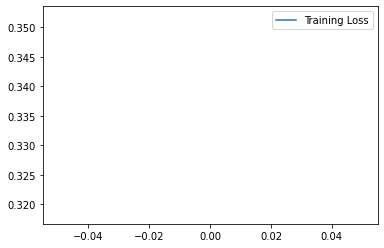

In [104]:
plt.plot(history["loss"], label="Training Loss")
plt.legend()
plt.show()

In [105]:
model.load_state_dict(best["state"])

<All keys matched successfully>

In [110]:
with open("LSTM_AE_model.pt", "wb") as f:
    torch.save(
        {
            "state": best["state"],
            "best_epoch": best["epoch"],
        },
        f,
    )

In [112]:
with open("LSTM_AE_model.pt", "rb") as f:
    SAVED_MODEL = torch.load(f)

model.load_state_dict(best["state"])

<All keys matched successfully>

# VALIDATION

In [49]:
def inference(dataloader, model):
    ts, dist, att = [], [], []
    with torch.no_grad():
        for batch in dataloader:
            given = batch["given"].to(device)
#             answer = batch["answer"].permute(0,2,1).to(device)
            guess = model(given)
            ts.append(np.array(batch["ts"]))
            dist.append(torch.abs(given - guess).cpu().numpy())
#             dist.append(torch.sum(torch.abs(guess-given), 1).cpu().numpy())
            try:
                att.append(np.array(batch["attack"]))
            except:
                att.append(np.zeros(64))
            
    return (
        np.concatenate(ts),
        np.concatenate(dist),
        np.concatenate(att),
    )

In [50]:
%%time
model.eval()
CHECK_TS, CHECK_DIST, CHECK_ATT = inference(validloader, model)

CPU times: user 99.9 ms, sys: 209 ms, total: 309 ms
Wall time: 265 ms


In [51]:
CHECK_DIST.shape

(959, 90, 86)

In [52]:
CHECK_ATT.shape

(959, 90)

In [144]:
class CNN_Detector(nn.Module):
    def __init__(self, input_dim=86, hidden_dim=32, output_dim=1):
        super(CNN_Detector, self).__init__()
        
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.hidden_dim = hidden_dim
        
        self.conv1d = torch.nn.Conv1d(self.input_dim, self.hidden_dim, kernel_size=3, padding =1)
        self.relu = torch.nn.ReLU()
        self.output_layer = torch.nn.Linear(self.hidden_dim, self.output_dim)
        #self.timedist = TimeDistributed(self.output_layer)
        
    def forward(self, x):
        x = x.permute(0,2,1)
        x = self.conv1d(x)
        x = x.permute(0,2,1)
        x = self.relu(x)
        x = self.output_layer(x)

        return x

In [145]:
class Linear_Detector(nn.Module):
    def __init__(self, input_dim=86, hidden_dim=32, output_dim=1):
        super(Linear_Detector, self).__init__()
        
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.hidden_dim = hidden_dim
        
        self.output_layer1 = torch.nn.Linear(self.input_dim, self.hidden_dim)
        self.timedist1 = TimeDistributed(self.output_layer1)
        self.relu = torch.nn.ReLU()
        self.output_layer2 = torch.nn.Linear(self.hidden_dim, self.output_dim)
        self.timedist2 = TimeDistributed(self.output_layer2)
        
    def forward(self, x):
        x = self.timedist1(x)
        x = self.relu(x)
        x = self.timedist2(x)
        return x

In [146]:
class Infer_Dataset(Dataset):
    def __init__(self, DIST, LABEL=None):
        self.DIST = np.array(DIST)

        if LABEL is not None:
            self.LABEL = np.array(LABEL)
            self.with_attack = True
        else:
            self.with_attack = False

    def __len__(self):
        return len(self.DIST)

    def __getitem__(self, idx):
        item = {"attack": self.LABEL[idx]} if self.with_attack else {}
        item["dist"] = self.DIST[idx]

        return item

In [147]:
VALID_DIST = Infer_Dataset(CHECK_DIST, CHECK_ATT)
VALID_DIST

In [148]:
params = {'batch_size': 64,
          'shuffle': True}

valdist_loader = DataLoader(VALID_DIST, **params)

In [149]:
iter(valdist_loader).next()

{'attack': tensor([[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]),
 'dist': tensor([[[1.2266e-02, 9.1479e-04, 9.2807e-02,  ..., 1.1807e-03,
           3.3146e-04, 5.6086e-02],
          [4.1631e-02, 8.6020e-04, 9.0514e-02,  ..., 3.3257e-04,
           2.0579e-05, 8.0284e-02],
          [1.0322e-01, 7.8609e-04, 9.1968e-02,  ..., 3.3365e-04,
           1.0273e-04, 7.0456e-02],
          ...,
          [5.7790e-02, 1.4373e-04, 8.8832e-02,  ..., 3.0546e-04,
           1.8341e-05, 4.4407e-04],
          [5.3105e-02, 1.2353e-04, 8.8813e-02,  ..., 3.1993e-04,
           1.6014e-05, 2.0487e-04],
          [5.3049e-02, 1.0287e-04, 8.8785e-02,  ..., 3.3344e-04,
           1.3500e-05, 5.9132e-05]],
 
         [[2.4100e-02, 4.5387e-04, 9.8248e-02,  ..., 5.4934e-04,
           9.0543e-06, 1.5098e-

In [150]:
iter(valdist_loader).next()['attack'].shape

torch.Size([64, 90])

In [151]:
optimizer = optim.AdamW(model.parameters())
loss_fn = nn.BCEWithLogitsLoss()

In [152]:
CNN_detector = CNN_Detector().to(device)
Linear_detector = Linear_Detector().to(device)

In [153]:
def detect_train(model, dataloader, optimizer, loss_fn, use_fp16=False, max_norm=None):
    
    epoch_loss = 0
    
    model.train() 

    for idx, batch in enumerate(dataloader):
        
        optimizer.zero_grad(set_to_none=True)
        #scaler = torch.cuda.amp.GradScaler()
                
        input = batch['dist'].to(device)
        attack = batch['attack'].to(device)
        
        predictions = model.forward(input)
        train_loss = loss_fn(torch.squeeze(predictions), attack)
        train_loss.backward()
        optimizer.step()
        
        epoch_loss += train_loss.item()
        
    return epoch_loss/len(dataloader)

## CNN_detector

In [154]:
%%time
epochs = 1
history = dict()
best = {"loss": sys.float_info.max}
early_stopping = EarlyStopping(patience=50, verbose=1)

for epoch in range(1, epochs+1):
    epoch_loss = detect_train(CNN_detector, valdist_loader, optimizer, loss_fn, use_fp16=True)
    #epoch_loss = detect_train(Linear_detector, valdist_loader, optimizer, loss_fn, use_fp16=True)
    history.setdefault('loss', []).append(epoch_loss) 
    
    print(f"[Train] Epoch : {epoch:^3}"\
        f"  Train Loss: {epoch_loss:.4}")
    if epoch_loss < best["loss"]:
            best["state"] = CNN_detector.state_dict()
            best["loss"] = epoch_loss
            best["epoch"] = epoch + 1
    if early_stopping.validate(epoch_loss):
        break

[Train] Epoch :  1   Train Loss: 0.6923
CPU times: user 32.2 ms, sys: 128 µs, total: 32.3 ms
Wall time: 66.8 ms


In [157]:
def detect(dataloader, model, mode=0):
    
    prediction = []
    
    if mode == 0:
        answer = []
    
    with torch.no_grad():
        for batch in dataloader:
            dist = batch["dist"].to(device)
            logit = torch.squeeze(model(dist)) #batch*90
            sig =torch.nn.Sigmoid()
            score = sig(logit)
            
            pred = (score > 0.5).int()
            prediction.append(pred.cpu().numpy())
            
            if mode == 0:
                answer.append(batch["attack"])
    
    if mode == 0:            
        return (
            np.concatenate(prediction),
            np.concatenate(answer)
        )
    else: 
        return np.concatenate(prediction)

In [158]:
val_pred, val_true = detect(valdist_loader, Linear_detector)
print(val_pred.shape)
print(val_true.shape)

(959, 90)
(959, 90)


In [ ]:
# 평가용
pred = []
true = [] 
for _ in range(0, len(val_pred), 90)
    pred.append(val_pred[_])
    true.append(val_true[_])

In [159]:
# val_pred = val_pred.flatten()
# val_true = val_true.flatten()

# print(val_pred.shape)
# print(val_true.shape)

(86310,)
(86310,)


In [160]:
TaPR = etapr.evaluate_haicon(anomalies=true, predictions=pred)
print(f"F1: {TaPR['f1']:.3f} (TaP: {TaPR['TaP']:.3f}, TaR: {TaPR['TaR']:.3f})")
print(f"# of detected anomalies: {len(TaPR['Detected_Anomalies'])}")
print(f"Detected anomalies: {TaPR['Detected_Anomalies']}")

F1: 0.000 (TaP: 0.000, TaR: 0.000)
# of detected anomalies: 0
Detected anomalies: []


In [161]:
Linear_detector(iter(valdist_loader).next()['dist'].to(device)).shape

torch.Size([64, 90, 1])

In [162]:
def check_graph(xs, att, piece=2, THRESHOLD=None):
    l = xs.shape[0]
    chunk = l // piece
    fig, axs = plt.subplots(piece, figsize=(20, 4 * piece))
    for i in range(piece):
        L = i * chunk
        R = min(L + chunk, l)
        xticks = range(L, R)
        axs[i].plot(xticks, xs[L:R])
        if len(xs[L:R]) > 0:
            peak = max(xs[L:R])
            axs[i].plot(xticks, att[L:R] * peak * 0.3)
        if THRESHOLD!=None:
            axs[i].axhline(y=THRESHOLD, color='r')
    plt.show()

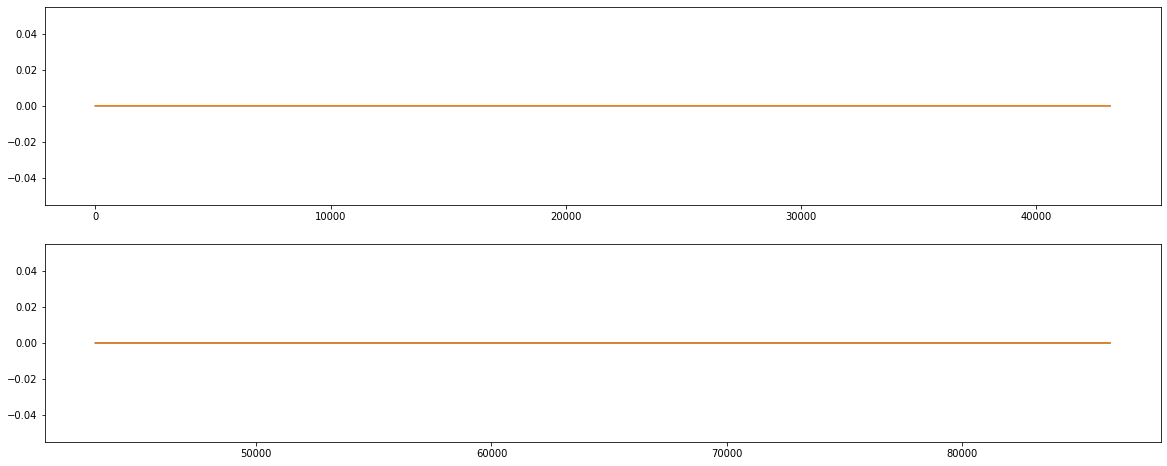

In [163]:
THRESHOLD = 2.5
check_graph(val_pred, val_true, piece=2)

In [107]:
def put_labels(distance, threshold):
    xs = np.zeros_like(distance)
    xs[distance > threshold] = 1
    return xs

In [113]:
LABELS = put_labels(ANOMALY_SCORE, THRESHOLD)
LABELS, LABELS.shape

(array([0., 0., 0., ..., 0., 0., 0.], dtype=float32), (86311,))

In [117]:
ATTACK_LABELS = put_labels(np.array(VALIDATION_DF_RAW[ATTACK_FIELD]), threshold=0.5)
ATTACK_LABELS, ATTACK_LABELS.shape

(array([0, 0, 0, ..., 0, 0, 0]), (86400,))

In [118]:
def fill_blank(check_ts, labels, total_ts):
    def ts_generator():
        for t in total_ts:
            yield dateutil.parser.parse(t)

    def label_generator():
        for t, label in zip(check_ts, labels):
            yield dateutil.parser.parse(t), label

    g_ts = ts_generator()
    g_label = label_generator()
    final_labels = []

    try:
        current = next(g_ts)
        ts_label, label = next(g_label)
        while True:
            if current > ts_label:
                ts_label, label = next(g_label)
                continue
            elif current < ts_label:
                final_labels.append(0)
                current = next(g_ts)
                continue
            final_labels.append(label)
            current = next(g_ts)
            ts_label, label = next(g_label)
    except StopIteration:
        return np.array(final_labels, dtype=np.int8)

In [119]:
%%time
FINAL_LABELS = fill_blank(CHECK_TS, LABELS, np.array(VALIDATION_DF_RAW[TIMESTAMP_FIELD]))
FINAL_LABELS.shape

CPU times: user 14.8 s, sys: 3.65 ms, total: 14.8 s
Wall time: 14.8 s


(86400,)

In [120]:
TaPR = etapr.evaluate_haicon(anomalies=ATTACK_LABELS, predictions=FINAL_LABELS)
print(f"F1: {TaPR['f1']:.3f} (TaP: {TaPR['TaP']:.3f}, TaR: {TaPR['TaR']:.3f})")
print(f"# of detected anomalies: {len(TaPR['Detected_Anomalies'])}")
print(f"Detected anomalies: {TaPR['Detected_Anomalies']}")

F1: 0.105 (TaP: 0.097, TaR: 0.113)
# of detected anomalies: 1
Detected anomalies: [<TaPR_pkg.DataManage.Range.Range object at 0x7fb7b1f733c8>]


In [121]:
%%time
model.eval()
CHECK_TS, CHECK_DIST, CHECK_ATT = inference(testloader, model)

CPU times: user 31.1 s, sys: 2.55 s, total: 33.6 s
Wall time: 28.4 s


In [122]:
ANOMALY_SCORE = np.mean(CHECK_DIST, axis=1)

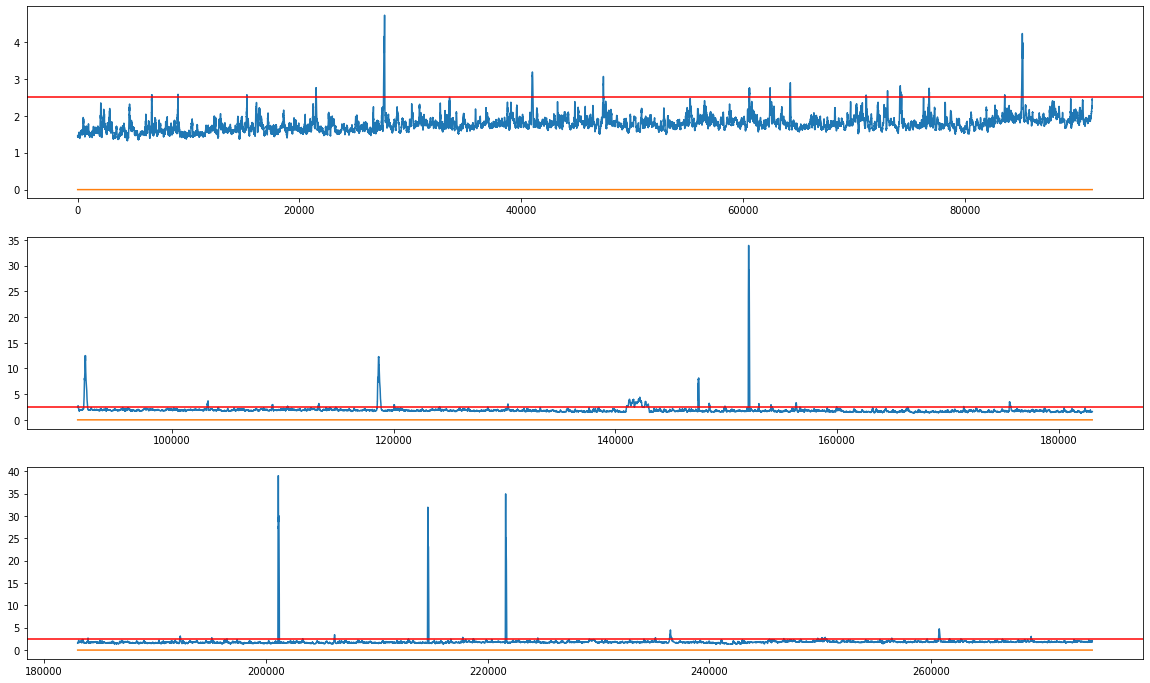

In [123]:
check_graph(ANOMALY_SCORE, CHECK_ATT, piece=3, THRESHOLD=THRESHOLD)

In [124]:
LABELS = put_labels(ANOMALY_SCORE, THRESHOLD)
LABELS, LABELS.shape

(array([0., 0., 0., ..., 0., 0., 0.], dtype=float32), (274533,))

In [125]:
submission = pd.read_csv('./HAICon2021_dataset/sample_submission.csv')
submission.index = submission['timestamp']
submission.loc[CHECK_TS,'attack'] = LABELS
submission

,timestamp,attack
timestamp,,
2021-07-13 16:00:01,2021-07-13 16:00:01,0.0
2021-07-13 16:00:02,2021-07-13 16:00:02,0.0
2021-07-13 16:00:03,2021-07-13 16:00:03,0.0
2021-07-13 16:00:04,2021-07-13 16:00:04,0.0
2021-07-13 16:00:05,2021-07-13 16:00:05,0.0
...,...,...
2021-07-16 23:59:56,2021-07-16 23:59:56,0.0
2021-07-16 23:59:57,2021-07-16 23:59:57,0.0
2021-07-16 23:59:58,2021-07-16 23:59:58,0.0


In [126]:
submission.to_csv('baseline.csv', index=False)